In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
# Load the training data
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

# Load the test data
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [3]:
# View the first 5 rows of the training data
print(train_df.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [4]:
# Check the shape of the datasets
print(f'Training data shape: {train_df.shape}')
print(f'Test data shape: {test_df.shape}')


Training data shape: (7613, 5)
Test data shape: (3263, 4)


In [5]:
# Check for missing values in training data
print(train_df.isnull().sum())


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [6]:
# Count the occurrences of each class
class_counts = train_df['target'].value_counts()
print(class_counts)


target
0    4342
1    3271
Name: count, dtype: int64


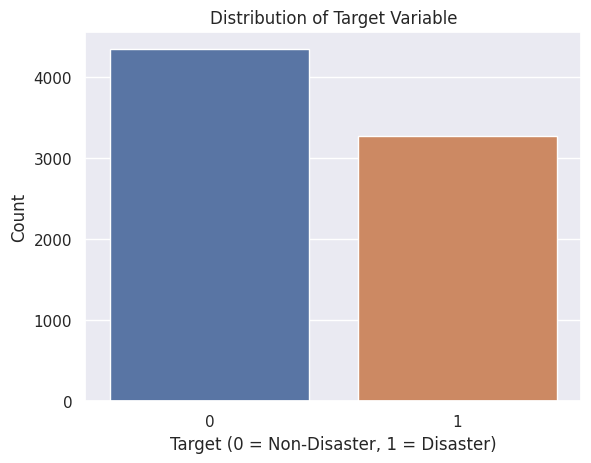

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for seaborn
sns.set(style="darkgrid")

# Plot the class distribution
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target (0 = Non-Disaster, 1 = Disaster)')
plt.ylabel('Count')
plt.show()


In [8]:
# Percentage of missing values in 'keyword' and 'location'
keyword_missing = train_df['keyword'].isnull().mean() * 100
location_missing = train_df['location'].isnull().mean() * 100

print(f"Percentage of missing 'keyword' values: {keyword_missing:.2f}%")
print(f"Percentage of missing 'location' values: {location_missing:.2f}%")


Percentage of missing 'keyword' values: 0.80%
Percentage of missing 'location' values: 33.27%


In [9]:
# Fill missing 'keyword' values with a placeholder
train_df['keyword'].fillna('no_keyword', inplace=True)
test_df['keyword'].fillna('no_keyword', inplace=True)

/tmp/ipykernel_30/1474296471.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['keyword'].fillna('no_keyword', inplace=True)
/tmp/ipykernel_30/1474296471.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [10]:
# Drop the 'location' column
train_df.drop(columns=['location'], inplace=True)
test_df.drop(columns=['location'], inplace=True)


In [11]:
import re
import string

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text


In [12]:
# Clean the 'text' column
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Clean the 'keyword' column
train_df['clean_keyword'] = train_df['keyword'].apply(clean_text)
test_df['clean_keyword'] = test_df['keyword'].apply(clean_text)


In [13]:
# Combine 'clean_text' and 'clean_keyword'
train_df['text_combined'] = train_df['clean_text'] + ' ' + train_df['clean_keyword']
test_df['text_combined'] = test_df['clean_text'] + ' ' + test_df['clean_keyword']


In [14]:
# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [24]:
# Optionally combine 'keyword' and 'text'
train_df['input_text'] = train_df['keyword'] + ' ' + train_df['text']
test_df['input_text'] = test_df['keyword'] + ' ' + test_df['text']

In [25]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['input_text'], train_df['target'], test_size=0.1, random_state=42)

In [26]:
# Initialize the tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# Tokenize the datasets
train_encodings = tokenizer(
    list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(
    list(val_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(
    list(test_df['input_text']), truncation=True, padding=True, max_length=128)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [29]:
import torch
class DisasterDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx])
                for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])

# Create datasets
train_dataset = DisasterDataset(train_encodings, train_labels)
val_dataset = DisasterDataset(val_encodings, val_labels)
test_dataset = DisasterDataset(test_encodings)



In [30]:
# Load RoBERTa for sequence classification
model = RobertaForSequenceClassification.from_pretrained('roberta-base')


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}


In [32]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    evaluation_strategy='epoch',     # evaluation strategy to adopt during training
    save_strategy='epoch',           # save strategy to adopt during training
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
)


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [33]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,     # custom compute_metrics function
)



In [34]:
# Train the model
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.534000,0.489480,0.804462,0.777943
2,0.381400,0.511512,0.807087,0.788489
3,0.339100,0.466275,0.821522,0.794562


TrainOutput(global_step=1287, training_loss=0.414165566573332, metrics={'train_runtime': 8473.2061, 'train_samples_per_second': 2.426, 'train_steps_per_second': 0.152, 'total_flos': 929452136389920.0, 'train_loss': 0.414165566573332, 'epoch': 3.0})

In [35]:
# Evaluate on the validation set
eval_result = trainer.evaluate()
print(f"Validation F1 Score: {eval_result['eval_f1']:.4f}")
print(f"Validation Accuracy: {eval_result['eval_accuracy']:.4f}")


Validation F1 Score: 0.7946
Validation Accuracy: 0.8215
